<a href="https://colab.research.google.com/github/matthieu-sgi/Pool_Ball_tracking_AI/blob/main/Ball_tracking_u_net.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
from __future__ import annotations

from matplotlib import pyplot as plt, cm
from PIL import Image, ImageOps
from scipy.ndimage import gaussian_filter
from torch.optim import SGD
from torch.nn import BatchNorm2d,Conv2d,MSELoss, Linear, MaxPool2d, Module, Sequential, ReLU , ConvTranspose2d, Upsample, CrossEntropyLoss, Sigmoid
from torch.utils.data import DataLoader, Dataset
from torchsummary import summary
from tqdm import tqdm

import numpy as np
import os,os.path
import pandas as pd
import time
import torch
import torch.nn.functional as F
import torchvision.transforms as T
import random

%matplotlib inline

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


# Dataset building

### Transforms

In [ ]:
class ToTen(object):
    """Convert PIL image and numpy ndarray in sample to Tensors."""

    def __call__(self, sample : dict) -> tuple[torch.tensor, torch.tensor] :
        image, masks = sample['image'], sample['target']
        masks_to_tensors = torch.from_numpy(masks)
        transform = T.ToTensor()
        return {'image': transform(image),
                'target': masks_to_tensors}
    @property
    def get_name(self) -> str:
      return "ToTensor"

### Dataset class

In [ ]:
class PoolImageDatasetSimplest(Dataset):
  global x_min,x_max,y_min,y_max, train_prop

  #Dimensions of my pool
  width , height = 1.900, 0.956
  x_min,x_max = -(width/2),width/2
  y_min,y_max = -(height/2),height/2
  train_prop = 0.75

  def __init__(
      self,
      transforms = None,
      csv_file_path : str = './coords.csv',
      data_path : str = "./images/",
      train : bool = True
      ) -> None:

    super().__init__()
    self.labels = pd.read_csv(csv_file_path)
    self.images_path = data_path
    self.transforms = transforms
    #define the resolution of the image in order to do the origine translation
    self.image_width, self.image_height = Image.open(data_path+"0.png").size
    # calling the cleaning function that includes mapping and translation of x and y
    self._clean_values()
    self.train = train
    self.len = self.__len__()

  @staticmethod
  def mapping_and_translation(
      value : float,
      actual_ref_min : float,
      actual_ref_max : float,
      offset : int # offset = translation quantity
      ) -> int : 
      
      new_ref_max = offset
      new_ref_min = -offset

       # +0.5 is just for the rounding by excess
       # And for the math formula I took the one from arduino function "map()"
      new_value = int(((value - actual_ref_min) * (new_ref_max - new_ref_min)/ (actual_ref_max - actual_ref_min) + new_ref_min))
      return new_value + offset
    
  def _clean_values(self):
    # Removing Z value 
    self.labels.drop('z', inplace = True,axis=1)
    #Removing all extreme X and Y values that are out of the pool table
    self.labels.drop(self.labels[(self.labels['x']>=x_max) | (self.labels['x'] <= x_min) ].index, inplace=True) 
    self.labels.drop(self.labels[(self.labels.y >= y_max) | (self.labels.y <= y_min) ].index, inplace=True) #

    #change coords if the translation changed
    self.labels["x"] = self.labels["x"].apply(lambda x : self.mapping_and_translation(x,x_min,x_max,int(self.image_width/2)))
    self.labels["y"] = self.labels["y"].apply(lambda y : self.mapping_and_translation(y,y_min,y_max,int(self.image_height/2)))
  
  def draw_ones(self,coords : np.ndarray) -> np.ndarray :
    # print(coords)
    arr = np.zeros((self.image_height,self.image_width),dtype = np.float32)
    for x, y in coords:
      arr[self.image_height - y,x] = 1.0 # self.image_height-y to flip
    # arr_gaussian = gaussian_filter(arr, sigma=1.5)
    # return torch.from_numpy(arr_gaussian)
    return arr.astype(dtype=np.float32)

  def __len__(self):
    return int(len(os.listdir(self.images_path)) * train_prop) if self.train else int(len(os.listdir(self.images_path)) * (1-train_prop))
  
  def __getitem__(self, idx) -> dict:
    if not self.train :
      idx = idx + self.len
    if torch.is_tensor(idx):
        idx = idx.tolist()

    img_name = os.path.join(self.images_path,
                              f"{str(idx)}.png")
    image = Image.open(img_name).convert('RGB') #Apply rgb conversion -> have 3 input channels instead of 4

    coords = np.array(self.labels[self.labels.id == idx].iloc[:,[1,2]])
    
    # print(coords)

    target = self.draw_ones(coords)
    # print(type(target[0]))
    sample = {'image': image, 'target': target}

    if self.transforms:
      sample = self.transforms(sample)


    return sample

In [ ]:
csv_file_path ="/content/drive/MyDrive/Createch/Pool_Project/.dataset/coords.csv"
data_path ="/content/drive/MyDrive/Createch/Pool_Project/.dataset/images/"

In [ ]:
dataset = PoolImageDatasetSimplest(csv_file_path=csv_file_path,data_path = data_path, train = True)

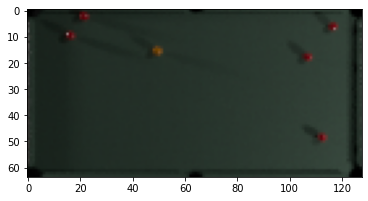

In [ ]:
plt.imshow(dataset[0]["image"])

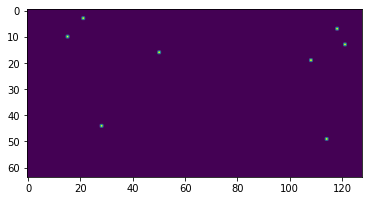

In [ ]:
target = dataset[0]["target"]
plt.imshow(target)

### DataLoader

In [ ]:
batch_size = 128
train_dataset = PoolImageDatasetSimplest(transforms=ToTen(),csv_file_path=csv_file_path,data_path = data_path,train = True)
test_dataset = PoolImageDatasetSimplest(transforms=ToTen(),csv_file_path=csv_file_path,data_path = data_path,train = False)
train_dataloader = DataLoader(train_dataset,batch_size=batch_size,shuffle = True,num_workers=2)
test_dataloader = DataLoader(test_dataset,batch_size=batch_size,shuffle = False,num_workers=2)

In [ ]:
train_dataset[0]["image"].size()

torch.Size([3, 64, 128])

# Model building

Building a U-Net, you have to define different parts of the model.

As the name indicate, it's built in U shape. First you have to go down, using convolution and pooling. Then you go up and add previous states.

At the end, we do an upscaling and conv to retrieve our original size.

### Building convolution

In [ ]:
class DoubleConv(Module):
    """(convolution => [BN] => ReLU) * 2"""

    def __init__(self, in_channels, out_channels, mid_channels=None):
        super().__init__()
        if not mid_channels:
            mid_channels = out_channels
        self.double_conv = Sequential(
            Conv2d(in_channels, mid_channels, kernel_size=3, padding=1, bias=False),
            BatchNorm2d(mid_channels),
            ReLU(inplace=True),
            Conv2d(mid_channels, out_channels, kernel_size=3, padding=1, bias=False),
            BatchNorm2d(out_channels),
            ReLU(inplace=True)
        )

    def forward(self, x):
        return self.double_conv(x)

### Building Down

In [ ]:
class Down(Module):
    """Downscaling with maxpool then double conv"""

    def __init__(self, in_channels, out_channels):
        super().__init__()
        self.maxpool_conv = Sequential(
            MaxPool2d(2),
            DoubleConv(in_channels, out_channels)
        )

    def forward(self, x):
        return self.maxpool_conv(x)

### Building Up

In [ ]:
class Up(Module):
    """Upscaling then double conv"""

    def __init__(self, in_channels, out_channels) : #, bilinear=True):
        super().__init__()

        # # if bilinear, use the normal convolutions to reduce the number of channels
        # if bilinear:
        #     self.up = Upsample(scale_factor=2, mode='bilinear', align_corners=True)
        #     self.conv = DoubleConv(in_channels, out_channels, in_channels // 2)
        # else:
        self.up = ConvTranspose2d(in_channels, in_channels // 2, kernel_size=2, stride=2)
        self.conv = DoubleConv(in_channels, out_channels)

    def forward(self, x1, x2):
        x1 = self.up(x1)
        # input is CHW
        diffY = x2.size()[2] - x1.size()[2]
        diffX = x2.size()[3] - x1.size()[3]

        x1 = F.pad(x1, [diffX // 2, diffX - diffX // 2,
                        diffY // 2, diffY - diffY // 2])

        x = torch.cat([x2, x1], dim=1)
        return self.conv(x)

### Building the final convolution


In [ ]:
class FinalConv(Module):
    def __init__(self, in_channels, out_channels):
        super(FinalConv, self).__init__()
        self.conv = Conv2d(in_channels, out_channels, kernel_size=1)

    def forward(self, x):
        return self.conv(x)

### Building the U-NET model


In [ ]:
class UNET(Module):
  def __init__(self, n_channels, n_classes,bilinear = False) -> None:
    super().__init__()

    self.n_channels = n_channels
    self.n_classes = n_classes
    self.bilinear = bilinear

    self.inc = DoubleConv(n_channels, 64)
    self.down1 = Down(64, 128)
    self.down2 = Down(128, 256)
    self.down3 = Down(256, 512)
    factor = 2 if bilinear else 1
    self.down4 = Down(512, 1024 // factor)
    self.up1 = Up(1024, 512 // factor)#, bilinear)
    self.up2 = Up(512, 256 // factor )#, bilinear)
    self.up3 = Up(256, 128 // factor )#, bilinear)
    self.up4 = Up(128, 64)#, bilinear)
    self.fconv = FinalConv(64, n_classes)
    self.sig = Sigmoid()

  def forward(self, x):
    x1 = self.inc(x)
    x2 = self.down1(x1)
    x3 = self.down2(x2)
    x4 = self.down3(x3)
    x5 = self.down4(x4)
    x = self.up1(x5, x4)
    x = self.up2(x, x3)
    x = self.up3(x, x2)
    x = self.up4(x, x1)
    logits = self.fconv(x)
    
    return self.sig(logits)



# Train

### hyperparameters

In [ ]:
model = UNET(3,1)
model.to("cuda")
lr = 1e-3
optimizer = SGD(model.parameters(),lr=lr)
criterion = CrossEntropyLoss()
criterion = criterion.to("cuda")
epochs = 3000

### Visualization setup


In [ ]:
!pip3 install wandb
import wandb

wandb.login()

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


wandb: WARNING Calling wandb.login() after wandb.init() has no effect.


True

In [ ]:

wandb.init(
      # Set the project where this run will be logged
      project="simplest_IA", 
      # We pass a run name (otherwise it’ll be randomly assigned, like sunshine-lollypop-10)
      name=f"experiment_for_final_results", 
      # Track hyperparameters and run metadata
      config={
      "learning_rate": lr,
      "architecture": "U-NET",
      "dataset": "Blender_Dataset",
      "dataset_size" : 10000,
      "loss" : "CrossEntropyLoss",
      "epochs": epochs,
      "batch_size": batch_size,

      })

In [ ]:
def step(model: Module, optim: torch.optim.Optimizer, criterion, loader: DataLoader, device: str = "cuda:0", train: bool = True) -> tuple[float, float] | float:


  avg_loss, avg_acc = 0.0, 0.0
  for sample in loader:
      
      x, target = sample["image"].to(device), sample["target"].to(device)


      y_: torch.Tensor = model(x)

      y_ = torch.squeeze(y_,dim=1)
      loss = criterion(y_,target)

      
      # acc = (y_.argmax(dim=-1) == target).sum()
      if train:
          optim.zero_grad(set_to_none=None)
          loss.backward()
          optim.step()
      avg_loss += loss.item() / len(loader)
      # avg_acc  += acc.item()  / len(loader.dataset)

  return avg_loss

      


### Valid loop

#### Useful functions

In [ ]:
def verif_close(coords : np.ndarray, x,y) -> bool:
  eps = 2
  for i in range(len(coords[0])):
    if coords[0][i] == x:
      return True if coords[1][i] - eps <= y and coords[1][i] + eps >= y else False
    
    if coords[1][i] == x:
      return True if coords[0][i] - eps <= y and coords[0][i] + eps >= y else False


In [ ]:

def get_center(input : torch.Tensor, kernel_size : int = 4) -> torch :
  width = input.size()[2]
  height = input.size()[1]
  ret = torch.zeros(1,height,width,dtype=torch.float32)
  for y  in range(height):
    for x in range(width):
      temp_value = input[0,y,x]
      if temp_value !=0 :
        min_x= 0 if x-kernel_size < 0 else x -kernel_size
        min_y= 0 if y-kernel_size < 0 else y -kernel_size
        max_x = width-1 if x+kernel_size> width else x+kernel_size 
        max_y = height-1 if y+kernel_size> height else y+kernel_size 
        local_max = temp_value
        # modif = False
        for j in range(min_y,max_y):
          for i in range(min_x,max_x):
            if input[0,j,i] > local_max and i > 2:
              local_max = input[0,j,i]
              modif = True

        ret[0,y,x] = 1 if temp_value == local_max and x >2 and x< width -3 else 0.0
  return ret
            

In [ ]:
def extract_coords(input : torch.Tensor)-> np.darray:
  coords = [[],[]]
  width = input.size()[1]
  height = input.size()[0]
  for y in range(height):
    for x in range(width):
      if input[y,x] == 1 and not verif_close(coords,x,y):
        coords[0].append(x)
        coords[1].append(y)
  return np.array(coords)

In [ ]:


def mean_euclidian_distance(target_coords : np.ndarray, predict_coords : np.ndarray) -> np.ndarray :
  dist = []
  for x,y in zip(target_coords[0],target_coords[1]):
    dist_min = (np.sqrt(np.power(x-predict_coords[0],2) + np.power(y-predict_coords[1],2))).min()
    dist.append(dist_min)
  return (np.array(dist)).mean()

#### Final Valid function

In [ ]:
def valid(model : Module, loader : DataLoader, device: str = "cuda:0", nb : int =  100, display : bool = False) -> float :
  mean_dist = 0.0
  nb_false_positive = 0.0
  nb_true_negative = 0.0
  # nb = nb_batch * batch_size

  y_ = None
  avg_loss, avg_acc = 0.0, 0.0
  start = time.time()
  for sample in loader:
    with torch.inference_mode() :

      x, target = sample["image"].to(device), sample["target"]
      y_: torch.Tensor = model(x)

      for _ in range(nb) :
        ind = random.randint(0,batch_size-1)
        # print(y_.size())
        # print("0 : ",y_[0].size())
        # print("1 : ",y_[1].size())
        # print("2 : ",y_[2].size())
        # print("3 : ",y_[3].size())
        thresh_function = torch.nn.Threshold(0.9,0,inplace = False)
        output_threshed = thresh_function(y_[ind])
        # print(output_threshed.size())
        output_centered = get_center(output_threshed)
        output_centered = torch.squeeze(output_centered,dim = 0)
        output_extracted, target_extracted= extract_coords(target[ind]),extract_coords(output_centered) 
        nb_false_positive += len(output_extracted) - len(target_extracted) if len(output_extracted) - len(target_extracted) >= 0 else  0.0
        nb_true_negative += -len(output_extracted) + len(target_extracted) if -len(output_extracted) + len(target_extracted) < 0 else  0.0

        dist = mean_euclidian_distance(output_extracted, target_extracted)
        mean_dist += dist
        print(f"distance : {dist:.2e} Sw for one inference : {time.time() - start}")
        if display : 
          output_displayed = torch.squeeze(y_[ind],dim=1)
          f, axarr = plt.subplots(2,2)
          axarr[0,0].imshow(to_pil(output_displayed))
          axarr[0,0].title.set_text("Raw output")

          axarr[0,1].imshow(to_pil(output_threshed))
          axarr[0,1].title.set_text("Threshed output")

          axarr[1,0].imshow(to_pil(output_centered))
          axarr[1,0].title.set_text("Local maximum output")

          axarr[1,1].imshow(to_pil(target))
          axarr[1,1].title.set_text("Target")
      mean_dist /= nb
      nb_false_positive /= nb
      nb_true_negative /= nb
      print(f"\nMean distance of the valid ({nb} runs) : {mean_dist:.2e}")
      print(f"Number of false positive {nb_false_positive:.2e} | Number of true negative {nb_true_negative:.2e}")

      return mean_dist
      # break


In [ ]:
# valid(model,test_dataloader, device = "cuda",nb= 100,display = False)

### Train

#### Train loop

In [ ]:
def train(
    model: Module,
    optim: torch.optim.Optimizer,
    criterion,
    train_loader: DataLoader,
    test_loader : DataLoader,
    device: str = "cuda:0",
    train: bool = True,
    epochs : int = 10
    ) -> None:
  best_loss = np.inf
  for i in tqdm(range(epochs)):

    # Train
    loss = step(model, optim, criterion, train_loader, train=True)
    wandb.log({"train_loss" : loss})

    # test
    loss = step(model,optim,criterion,test_loader,train = False)
    wandb.log({"test_loss" : loss})
    if True:
      mean_dist = valid(model, test_loader)
      print(mean_dist)
      if mean_dist < 3.0 :
        print("Objectif aschieved")
        best_loss = loss
        torch.save(model.state_dict(),"/content/drive/MyDrive/Createch/Pool_Project/weigths/best_upgrade.txt")
        break

    if loss < best_loss:
      best_loss = loss
      torch.save(model.state_dict(),"/content/drive/MyDrive/Createch/Pool_Project/weigths/best_upgrade.txt")

#### Training

In [ ]:
try :
  train(model,optim = optimizer,criterion = criterion,train_loader = train_dataloader, test_loader = test_dataloader, device="cuda:0", epochs=epochs)
except KeyboardInterrupt:
  torch.save(model.state_dict(),"/content/drive/MyDrive/Createch/Pool_Project/weigths/best_upgrade.txt")

  0%|          | 0/3000 [00:00<?, ?it/s]

distance : 9.41e-01 Sw for one inference : 2.159303903579712
Mean distance of the valid (1 runs) : 9.41e-01
Number of false positive 0.00e+00 | Number of true negative 0.00e+00
0.9414213562373096
Objectif aschieved


  0%|          | 0/3000 [01:14<?, ?it/s]


# Inference

### Testing 

In [ ]:
####################################### For testing purpose only #########################################
model = UNET(3,1)
model.load_state_dict(torch.load("/content/drive/MyDrive/Createch/Pool_Project/weigths/best_upgrade.txt", map_location = torch.device('cuda')))
model.eval()
model.cuda() ####TO CHANGE IF I HAVE COLAB CREDITS

In [ ]:
sample = None
for i, batch in enumerate(test_dataloader):
  if i == 0:
    sample = batch
    break
print(type(sample))
transform = ToTen()
# sample = transform(sample)
image_sample , target= sample["image"].to('cuda'), sample["target"][0]
output = model(image_sample)
# output = None
# 
# for sample in test_dataloader:
  # with torch.inference_mode() :
    # x, target = sample["image"].to("cuda"), sample["target"]
    # break
# output

<class 'dict'>


In [ ]:
# image_sample
output.max()
thresh = torch.nn.Threshold(0.9,0,inplace = False)
logic = thresh(output[0])
logic
# torch.max(output)

tensor([[[0., 0., 0.,  ..., 0., 0., 0.],
         [0., 0., 0.,  ..., 0., 0., 0.],
         [0., 0., 0.,  ..., 0., 0., 0.],
         ...,
         [0., 0., 0.,  ..., 0., 0., 0.],
         [0., 0., 0.,  ..., 0., 0., 0.],
         [0., 0., 0.,  ..., 0., 0., 0.]]], device='cuda:0',
       grad_fn=<ThresholdBackward0>)

In [ ]:
hope_centered = get_center(logic)

In [ ]:
hope_centered = torch.squeeze(hope_centered, dim = 0)
hope_centered.size()

torch.Size([64, 128])

In [ ]:
predict_coords = extract_coords(hope_centered)
print(f"Model output coords (x y) : \n{predict_coords}")
# print(target.size())
target_coords = extract_coords(target)
print(f"Target coords (x y) : \n{target_coords}")

Model output coords (x y) : 
[[  5 120  47  52  62  15 111]
 [  8  15  29  37  55  56  59]]
Target coords (x y) : 
[[  3 121  46  51  61  14 112]
 [  8  15  29  36  54  56  59]]


In [ ]:
dist = mean_euclidian_distance(target_coords,predict_coords)
dist

1.2612038749637413

In [ ]:
# model = UNET(3,1)
# model.load_state_dict(torch.load("/content/drive/MyDrive/Createch/Pool_Project/weigths/best_upgrade.txt", map_location = torch.device('cuda')))
# model.eval()
# model.cuda() ####TO CHANGE IF I HAVE COLAB CREDITS


In [ ]:
# summary(model,(128,64))
summary(model,(3,64,128),batch_size=batch_size)

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1         [128, 64, 64, 128]           1,728
       BatchNorm2d-2         [128, 64, 64, 128]             128
              ReLU-3         [128, 64, 64, 128]               0
            Conv2d-4         [128, 64, 64, 128]          36,864
       BatchNorm2d-5         [128, 64, 64, 128]             128
              ReLU-6         [128, 64, 64, 128]               0
        DoubleConv-7         [128, 64, 64, 128]               0
         MaxPool2d-8          [128, 64, 32, 64]               0
            Conv2d-9         [128, 128, 32, 64]          73,728
      BatchNorm2d-10         [128, 128, 32, 64]             256
             ReLU-11         [128, 128, 32, 64]               0
           Conv2d-12         [128, 128, 32, 64]         147,456
      BatchNorm2d-13         [128, 128, 32, 64]             256
             ReLU-14         [128, 128,

torch.Size([1, 64, 128])


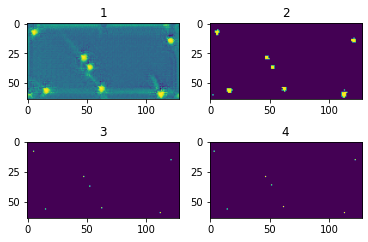

In [ ]:
f, axarr = plt.subplots(2,2)

to_pil = T.ToPILImage()
print(logic.size())

# print(logic.size())

axarr[0,0].imshow(to_pil(output[0]))
axarr[0,0].title.set_text("1")

axarr[0,1].imshow(to_pil(logic))
axarr[0,1].title.set_text("2")

axarr[1,0].imshow(to_pil(hope_centered))
axarr[1,0].title.set_text("3")

axarr[1,1].imshow(to_pil(target))
axarr[1,1].title.set_text("4")
